Authors:
    <br>Alejandro Alvarez (axa)
    <br>Brenda Palma (bpalmagu)

# <center>ML-Jokes: Content-Based Filtering</center>

In [1]:
# Path to ml-jokes folder
import os
if os.getcwd().split('/')[-2] == 'ml-jokes': os.chdir('..')
print(f'Current directory: {os.getcwd()}')
assert set(['data', 'mljokes', 'environment.yml', 'nbs']) <= set(os.listdir()), \
    'Wrong path; go to ./heinz-95729-project/api/ml-jokes'

Current directory: /home/alejandroxag/my_files/heinz-95729-project/api/ml-jokes


In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Info loading

In [3]:
with open('./results/model_inputs_nov28.pkl', 'rb') as f: model_inputs = pickle.load(f)
with open('./results/predictions_nov28.pkl', 'rb') as f: predictions = pickle.load(f)
predictions.rename(columns={'joke:id': 'joke_id'}, inplace=True)

# Recommendations

### Recommendation system

In [141]:
def recommend(user_id, model_inputs, predictions):
       ratings = model_inputs['user_joke_info'].copy() \
                     [model_inputs['user_joke_info'].user_id == user_id] \
                     .merge(predictions[model_inputs['user_joke_info'].user_id == user_id],
                            how='left', on=['user_id', 'joke_id']) \
                     .drop(columns=['test_user','test_example', 'val_example', 'training_example', 'len'] ) \
                     .iloc[:, [0, 1, 3, 2, -1] + list(range(4, len(model_inputs['user_joke_info'].columns) - 5))]
       ratings.insert(3, 'user_rating', 
                     ratings.rating * (1 * (ratings.rating != 99)) + \
                     ratings.rating_pred * (1 * (ratings.rating == 99)))
       ratings.drop(columns=['rating', 'rating_pred'], inplace=True)
       ratings.insert(3, 'rank', ratings \
                                          .groupby(['user_id', 'unseen_joke']) \
                                          .user_rating \
                                          .rank(method='dense', ascending=False))
       
       ratings = ratings.merge(model_inputs['jokes_df'].loc[:, ['joke_id', 'text']], 
                                   how='left', on='joke_id')

       ratings.sort_values(by=['unseen_joke', 'rank', 'joke_id'], inplace=True)

       return ratings
    
def get_user_preferences(user_id, model_inputs, predictions):
       recommendations_df = recommend(user_id, model_inputs, predictions)
       return recommendations_df \
                     .reset_index(drop=True) \
                     .loc[:, list(np.array(model_inputs['features']) \
                                   [pd.Series(model_inputs['features']) \
                                   .str.contains('user')])] \
                     .drop_duplicates().iloc[0]

def get_jokes(user_id, model_inputs, predictions, n_jokes, unseen=False):
       recommendations_df = recommend(user_id, model_inputs, predictions)
       topics_features = list(np.array(model_inputs['features']) \
                                             [pd.Series(model_inputs['features']) \
                                              .str.contains('percentage')])

       return recommendations_df \
                     .loc[recommendations_df.unseen_joke == unseen] \
                     .reset_index(drop=True) \
                     .iloc[:n_jokes, :] \
                     .loc[:, ['rank', 'user_rating', 'joke_id', 'unseen_joke', 'text'] + topics_features]

def plot_joke(jokes_rated, jokes_unseen, user_id):
       sns.set(rc={'axes.facecolor':'#37474f', 'figure.facecolor':'#37474f', 'patch.linewidth': 0.0})
       
       # Construct plot
       fig, ax = plt.subplots(3, 2, sharey=True, sharex=True)
       plt.subplots_adjust(wspace=0.3, hspace=0.5)
       fig.set_size_inches(15, 7)
       fig.suptitle(f'Jokes\' topic distribution (top 3 rated by User {user_id})', color='white')
       for idx, row in jokes_rated.iterrows():
              p = sns.barplot(x=row[5:].index.str.slice(-1).astype(int) + 1, 
                                       y=row[5:].values, ax=ax[idx, 0])
              p.annotate(f"User rating:\n{row.loc['user_rating']:0.1f}", xy=(0.2, 0.7), color='white')
              p.set_ylim((0, 1))
              p.set_title(f'Top {idx + 1} rated joke', color='white')
              p.xaxis.label.set_color('white')
              p.tick_params(colors='white')
              p.spines['bottom'].set_color('#37474f')
              p.spines['top'].set_color('#37474f')
              p.spines['right'].set_color('#37474f')
              p.spines['left'].set_color('#37474f')
              p.grid(False)
       p.set_xlabel('topic')

       for idx, row in jokes_unseen.iterrows():
              p = sns.barplot(x=row[5:].index.str.slice(-1).astype(int) + 1, 
                                       y=row[5:].values, ax=ax[idx, 1])
              p.annotate(f"User rating:\n{row.loc['user_rating']:0.1f}", xy=(0.2, 0.7), color='white')
              p.set_ylim((0, 1))
              p.set_title(f'Top {idx + 1} predicted joke', color='white')
              p.xaxis.label.set_color('white')
              p.tick_params(colors='white')
              p.spines['bottom'].set_color('#37474f')
              p.spines['top'].set_color('#37474f')
              p.spines['right'].set_color('#37474f')
              p.spines['left'].set_color('#37474f')
              p.grid(False)

       p.set_xlabel('topic')
      
       plt.show()

def plot_user_pref(user_pref, user_id):
       # Set Seaborn style
       sns.set(rc={'axes.facecolor':'#37474f', 'figure.facecolor':'#37474f','patch.linewidth': 0.0})

       # Construct plot
       fig, ax = plt.subplots(1, 1, sharey=True, sharex=True)
       fig.set_size_inches(13, 9)
       p = sns.barplot(x=user_pref.index.str.slice(-1).astype(int) + 1, 
                       y=user_pref.values)
       p.set_xlabel('topic', color='white')
       p.set_title(f'User {user_id} preferences distribution per topic', color='white')
       p.tick_params(colors='white')
       p.spines['bottom'].set_color('#37474f')
       p.spines['top'].set_color('#37474f')
       p.spines['right'].set_color('#37474f')
       p.spines['left'].set_color('#37474f')
       p.grid(False)
       plt.show()

In [142]:
# user_id = 4493
# n_top = 3

# recommendation = recommend(user_id=user_id, 
#                            model_inputs=model_inputs,
#                            predictions=predictions)

# user_pref = get_user_preferences(user_id=user_id, 
#                                  model_inputs=model_inputs,
#                                  predictions=predictions)

# top_n_jokes_rated = get_jokes(user_id=user_id, 
#                         model_inputs=model_inputs, 
#                         predictions=predictions, 
#                         n_jokes=n_top, 
#                         unseen=False)

# top_n_jokes_unseen = get_jokes(user_id=user_id, 
#                         model_inputs=model_inputs, 
#                         predictions=predictions, 
#                         n_jokes=n_top, 
#                         unseen=True)

In [144]:
# plot_user_pref(user_pref, user_id)
# plot_joke(top_n_jokes_rated, top_n_jokes_unseen, user_id)
# for joke in top_n_jokes_rated.text: print(f'\n\n{joke}')
# for joke in top_n_jokes_unseen.text: print(f'\n\n{joke}')

### Model errors

In [4]:
ratings = model_inputs['user_joke_info'] \
              [model_inputs['user_joke_info'].test_example == 1] \
              .loc[:, ['user_id', 'joke_id', 'rating']] \
              .merge(predictions[model_inputs['user_joke_info'].test_example == 1],
                     how='left', on=['user_id', 'joke_id'])
ratings.insert(4, 'error', np.abs(ratings.rating - ratings.rating_pred))

<AxesSubplot:ylabel='Frequency'>

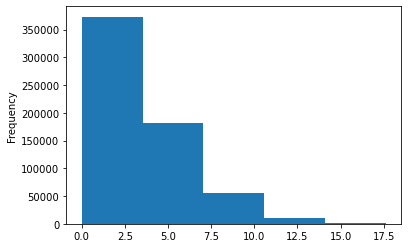

In [5]:
ratings.error.plot.hist(bins=5)

In [15]:
model_inputs['user_joke_info'][model_inputs['user_joke_info'].test_example == 1]

,user_id,joke_id,rating,len,test_user,unseen_joke,test_example,val_example,training_example,topic_percentage_0,...,topic_user_rating_0,topic_user_rating_1,topic_user_rating_2,topic_user_rating_3,topic_user_rating_4,topic_user_rating_5,topic_user_rating_6,topic_user_rating_7,topic_user_rating_8,topic_user_rating_9
6,0,7,-0.78,15,0,0,1,0,0,0.012502,...,-0.001177,-0.000419,0.032935,-0.009721,-0.000419,-0.032344,0.005908,-0.036297,0.027046,-0.020807
7,0,8,6.89,16,0,0,1,0,0,0.012500,...,-0.001177,-0.000419,0.032935,-0.009721,-0.000419,-0.032344,0.005908,-0.036297,0.027046,-0.020807
12,0,13,-2.57,16,0,0,1,0,0,0.011112,...,-0.001177,-0.000419,0.032935,-0.009721,-0.000419,-0.032344,0.005908,-0.036297,0.027046,-0.020807
35,0,36,1.26,65,0,0,1,0,0,0.972725,...,-0.001177,-0.000419,0.032935,-0.009721,-0.000419,-0.032344,0.005908,-0.036297,0.027046,-0.020807
47,0,48,-8.20,48,0,0,1,0,0,0.004167,...,-0.001177,-0.000419,0.032935,-0.009721,-0.000419,-0.032344,0.005908,-0.036297,0.027046,-0.020807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7342039,73420,40,0.19,25,0,0,1,0,0,0.930762,...,0.029091,0.006308,0.027339,0.070627,0.019282,0.034646,0.080404,0.026061,0.036333,0.032007
7342043,73420,44,-0.53,13,0,0,1,0,0,0.012502,...,0.029091,0.006308,0.027339,0.070627,0.019282,0.034646,0.080404,0.026061,0.036333,0.032007
7342047,73420,48,-6.12,48,0,0,1,0,0,0.004167,...,0.029091,0.006308,0.027339,0.070627,0.019282,0.034646,0.080404,0.026061,0.036333,0.032007
7342051,73420,52,4.81,20,0,0,1,0,0,0.010001,...,0.029091,0.006308,0.027339,0.070627,0.019282,0.034646,0.080404,0.026061,0.036333,0.032007
